In [1]:
# header files 
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sn
from collections import Counter
from matplotlib.patches import Ellipse

# Reading the synthetic data into pandas dataframe
train_dataset = np.genfromtxt(r"dataset\Dataset_1B\train.csv",delimiter=',')
feature_train = train_dataset[:,0:2] 
class_train = train_dataset[:,2]
dev_dataset = np.genfromtxt(r"dataset\Dataset_1B\dev.csv",delimiter=',')

# number of features
d = 2

# creating test/validation data from the dataset given
feature_test = np.zeros((int(len(dev_dataset)/2),d))
class_test = np.zeros(int(len(dev_dataset)/2))
feature_dev = np.zeros((int(len(dev_dataset)/2),d))
class_dev = np.zeros(int(len(dev_dataset)/2))
for i in range(len(dev_dataset)):
    if i%2:
        feature_test[int((i-1)/2)] = dev_dataset[i,0:2]
        class_test[int((i-1)/2)] = dev_dataset[i,2]
    else:
        feature_dev[int(i/2)] = dev_dataset[i,0:2]
        class_dev[int(i/2)] = dev_dataset[i,2]

# Identifying the number of classes in the data      
classes = set(class_train)
class_count = len(classes)

# array to check various values of K used in different classfication methods
K = [1,7,15]
K1 = [10,20]

In [2]:
# generating meshgrid    
X1_lim = np.arange(start = feature_train[:,0].min()-1, stop = feature_train[:,0].max()+1,step = 0.15)
X2_lim = np.arange(start = feature_train[:,1].min()-1, stop = feature_train[:,1].max()+1,step = 0.15)
XX,YY = np.meshgrid(X1_lim,X2_lim)

#Converting XX,YY to 1D array, then changing its number of columns to 2
reshape_array = np.array([XX.ravel(),YY.ravel()]).T
assign_class_plot_boundary = np.zeros(len(reshape_array))

pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY

# to plot the decision surface in the given region
# input : classification of all the points in the given region, k
def plotDecisionSurface(assign_class_plot_boundary, k): 
    # Plotting decision surface
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    ax.contourf(XX,YY,assign_class_plot_boundary.reshape(XX.shape), cmap = 'Pastel1')
    ax.scatter(feature_train[:,0],feature_train[:,1],c = class_train, cmap = 'Dark2')
    plt.show()

In [3]:
# draw an ellipse with the given mean and covariance values
# input: position of the center and the covariance matrix 
def draw_ellipse(position, covariance,ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()  
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, (nsig * width)/1.5, (nsig * height)/1.5,angle,**kwargs))

In [4]:
# function to generate the countour function for plotting
# input : mean and covariance of the distribution
def countour_function(mean,cov):
    Sigma_det = np.linalg.det(cov)
    Sigma_inv = np.linalg.inv(cov)
    a = np.einsum('...k,kl,...l->...', pos-mean, Sigma_inv, pos-mean)
    return np.exp(-a / 2)/((2*(math.pi)**(d/2))*np.sqrt(Sigma_det))

In [5]:
# Plots the contours of the probability destribution of each class using GMM
# input : classification region, means and covariances of each class distribution
def plotDecisionSurfaceGMM(assign_class_plot_boundary,Q,mean,cov):
    fig3 = plt.figure(figsize = (10, 7))
    ax3 = fig3.add_subplot(111)

    for j in range(class_count):
        for i in range(Q):
            if(j == 0):
                draw_ellipse(mean[j][i],cov[j][i],alpha = 1,edgecolor='red',fill = False)
            elif(j == 1):
                draw_ellipse(mean[j][i],cov[j][i],alpha = 1,edgecolor='blue',fill = False)
            elif(j == 2):
                draw_ellipse(mean[j][i],cov[j][i],alpha = 1,edgecolor='green',fill = False)   

    ax3.contourf(XX, YY,assign_class_plot_boundary.reshape(XX.shape),cmap = 'Pastel1')
    ax3.scatter(feature_train[:,0],feature_train[:,1],c = class_train, cmap = 'Set1',alpha=0.7)
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')

    plt.show()
    
    Z_1 =np.zeros((class_count,Q,XX.shape[0],XX.shape[1]))
    for i in range(class_count):
        for j in range(Q):
            Z_1[i][j] = countour_function(pos,mean[i][j],cov[i][j]) 

    fig2 = plt.figure(figsize = (14, 10))
    ax2 = fig2.gca(projection='3d')
    plt.xlim([min(feature_train[:,0])-2, max(feature_train[:,0])+2])
    plt.ylim([min(feature_train[:,1])-2, max(feature_train[:,1])+2])

    step = 1
    for j in range(Q): 
        m = np.amax(Z_1[0][j])
        levels = np.arange(0.0, m, step) + step
        ax2.plot_surface(XX, YY, Z_1[0][j],cmap='Reds' ,rstride=3, cstride=3,alpha = 0.6)
        counto0 = ax2.contour(XX, YY,  Z_1[0][j],levels, offset=-3.15, cmap='hot')
    for j in range(Q):
        m = np.amax(Z_1[1][j])
        levels = np.arange(0.0, m, step) + step
        ax2.plot_surface(XX, YY, Z_1[1][j],cmap='Blues',rstride=3, cstride=3,alpha = 0.5)
        counto0 = ax2.contour(XX, YY,  Z_1[1][j],levels , offset=-3.15, cmap='winter')
    for j in range(Q):
        m = np.amax(Z_1[2][j])
        levels = np.arange(0.0, m, step) + step
        ax2.plot_surface(XX, YY, Z_1[2][j],cmap='Greens',rstride=3, cstride=3,alpha = 0.5)
        counto0 = ax2.contour(XX, YY,  Z_1[2][j],levels, offset=-3.15, cmap='summer')

    ax2.set_zlim(-3.15,12)        
    ax2.view_init(10, 35)
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('Z')
    plt.show()

In [6]:
# for printing Heatmap of the confusion matrix
# input : confusion matrix
def printheatmap(c):
    sn.heatmap(c,annot=True,fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show() 

In [7]:
# returns the euclidian distance between 2 points 
# inputs : takes 2 points
def Euclidean_distance(data1,data2):
    return math.sqrt(sum((data1-data2)**2))

In [13]:
# returns the k nearest neighbours of the test instance
# input : the test instance ,the value of k
def get_neighbors(test_instance,k):
    distances = []
    for i in range(len(feature_train)):
        dist = Euclidean_distance(test_instance,feature_train[i])
        distances.append((feature_train[i], dist, class_train[i]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors

In [10]:
# returns the predicted class of the test instance as per the KNN density based classification
# input : the test instance ,the value of k
def get_neighbors_class(test_instance,k):
    distances = []
    for i in range(len(feature_train)):
        dist = Euclidean_distance(test_instance,feature_train[i])
        distances.append((feature_train[i], dist, class_train[i]))
    distances.sort(key=lambda x: x[1])
    class_elements = np.zeros(class_count)
    for distance in distances:
        class_elements[int(distance[2])]+=1
        if(class_elements[int(distance[2])] == k):
            return int(distance[2])
    return -1

In [9]:
# returns the class that has maximum number of neighbours
# input : list of k nearest neighbours
def vote(neighbors):
    class_counter = Counter()
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1
    return class_counter.most_common(1)[0][0]

In [15]:
# returns the confusion matrix for all elements in data points
# inputs : value of k, data points, actual class labels for the data points
def KNN_classifier(k,data,label):
    predicted_class = np.zeros(len(label))
    confusion_matrix = np.zeros((class_count,class_count),dtype= int)
    for i in range(len(data)):
        predicted_class[i] = vote(get_neighbors(data[i],k))
        confusion_matrix[int(predicted_class[i])][int(label[i])]+=1
    return confusion_matrix


Confusion matrix for training data, when k = 1:


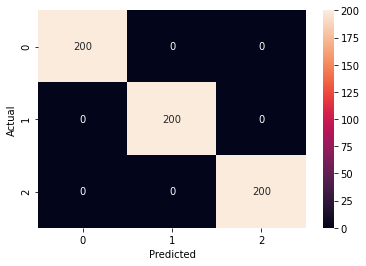


Confusion matrix for test data, when k = 1:


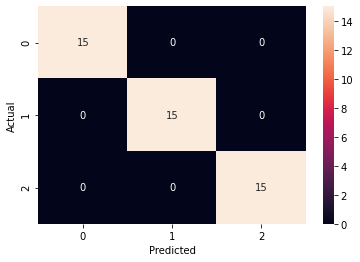


Decision Surface of the region, when k = 1:


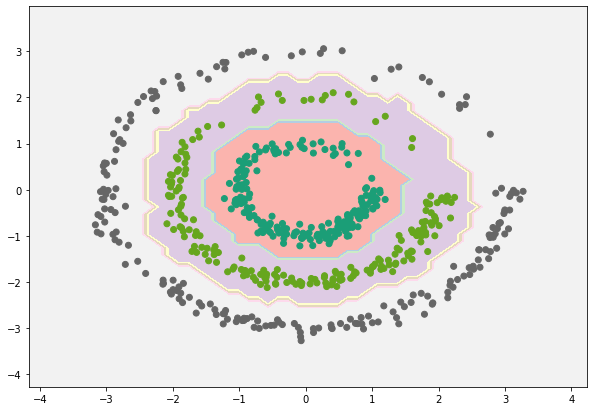

Accuracy on training data, when k = 1 : 100.0%

Accuracy on validation data, when k = 1 : 100.0%

Accuracy on test data, when k = 1 : 100.0%



Confusion matrix for training data, when k = 7:


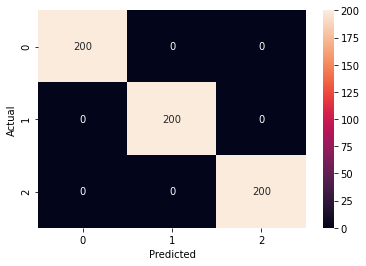


Confusion matrix for test data, when k = 7:


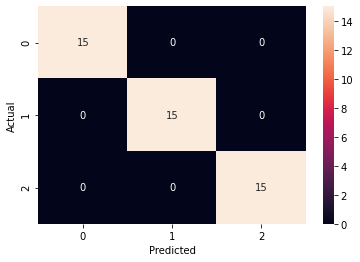


Decision Surface of the region, when k = 7:


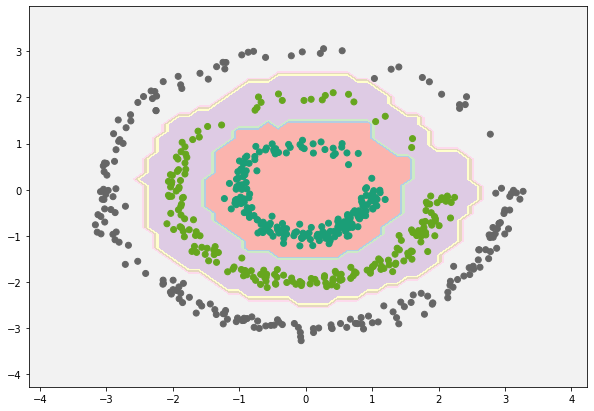

Accuracy on training data, when k = 7 : 100.0%

Accuracy on validation data, when k = 7 : 100.0%

Accuracy on test data, when k = 7 : 100.0%



Confusion matrix for training data, when k = 15:


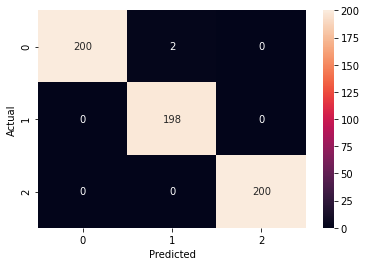


Confusion matrix for test data, when k = 15:


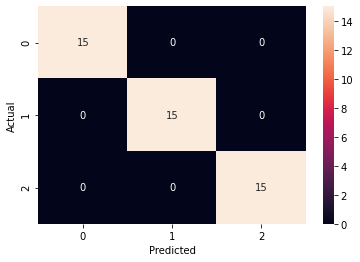


Decision Surface of the region, when k = 15:


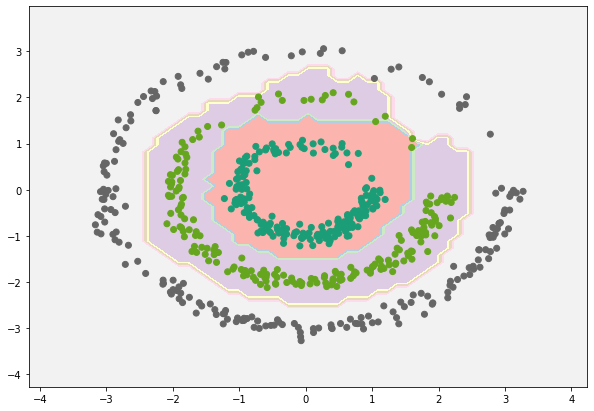

Accuracy on training data, when k = 15 : 99.66666666666667%

Accuracy on validation data, when k = 15 : 100.0%

Accuracy on test data, when k = 15 : 100.0%




In [16]:
# array to store the classification accuracies for each of the datasets
accuracy_dev = np.zeros(len(K))
accuracy_train = np.zeros(len(K))
accuracy_test = np.zeros(len(K))

for i in range(len(K)):
    confusion_matrix = KNN_classifier(K[i],feature_train,class_train)
    accuracy_train[i] = np.trace(confusion_matrix)/len(class_train)*100
    print("\nConfusion matrix for training data, when k = "+str(K[i])+":")
    printheatmap(confusion_matrix)
    confusion_matrix = KNN_classifier(K[i],feature_dev,class_dev)
    accuracy_dev[i] = np.trace(confusion_matrix)/len(class_dev)*100
    confusion_matrix = KNN_classifier(K[i],feature_test,class_test)
    accuracy_test[i] = np.trace(confusion_matrix)/len(class_test)*100
    print("\nConfusion matrix for test data, when k = "+str(K[i])+":")
    printheatmap(confusion_matrix)

    # Clasifying every point on meshgrid
    for j in range(len(reshape_array)):
        assign_class_plot_boundary[j] = vote(get_neighbors(reshape_array[j],K[i]))

    # Plotting the decision surface
    print("\nDecision Surface of the region, when k = "+str(K[i])+":")
    plotDecisionSurface(assign_class_plot_boundary,K[i])

    print("Accuracy on training data, when k = "+str(K[i])+" : "+str(accuracy_train[i])+"%\n")
    print("Accuracy on validation data, when k = "+str(K[i])+" : "+str(accuracy_dev[i])+"%\n")
    print("Accuracy on test data, when k = "+str(K[i])+" : "+str(accuracy_test[i])+"%\n\n")

In [13]:
def gaussianPrabability(data,mean,cov):
    u = data-mean
    exp = -0.5*(u.transpose().dot(np.linalg.inv(cov)).dot(u))
    return math.e**(exp)/( ((2*math.pi)**(d/2))*math.sqrt(np.linalg.det(cov)) )

In [14]:
def assignCluster(mean,data,k):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        closest = Euclidean_distance(data[i],mean[0])**2
        z[i][0] = 1
        for j in range(len(mean)):
            dist = Euclidean_distance(data[i],mean[j])**2
            if(dist < closest):
                closest = dist
                z[i] = np.zeros(k)
                z[i][j] = 1
    return z

In [15]:
def updateMean(z,data,k):
    mean = np.zeros((k,d))
    N = sum(z)
    for i in range(k):
        for j in range(len(data)):
            mean[i]+=data[j]*z[j][i]
        mean[i]/=N[i]
    return mean

In [16]:
def updateCov(z,data,k,mean):
    N = sum(z)
    cov = [np.zeros((d,d)) for rows in range(k)]
    for i in range(k):
        for j in range(len(data)):
            u = data[j]-mean[i]
            cov[i]+= z[j][i]*np.outer(u,u.transpose())
        cov[i]/=N[i]
    return cov

In [17]:
def KmeansClustering(k,data,iteration):
    mean = np.zeros((k,d))
    mean_index_initial = np.random.choice(len(data),k)    
    for i in range(k):
        mean[i] = data[mean_index_initial[i]]
    z_old = assignCluster(mean,data,k)
    for i in range(iteration):
        mean = updateMean(z_old,data,k)
        z_new = assignCluster(mean,data,k)
        if np.allclose(z_new,z_old):
            break
        z_old = z_new
    return mean

In [18]:
def likelihood(k,w,data,mean,cov):
    likelihood = 0
    for i in range(k):
        likelihood += w[i]*gaussianPrabability(data,mean[i],cov[i])
    return likelihood

In [19]:
def totalLogLikelihood(data,k,w,mean,cov):
    totalLikelihood = 0
    for i in range(len(data)):
        totalLikelihood += np.log(likelihood(k,w,data[i],mean,cov))
    return totalLikelihood

In [20]:
def ExpectationStep(data,k,w,mean,cov):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        denominator = 0
        for j in range(k):
            z[i][j] = w[j]*gaussianPrabability(data[i],mean[j],cov[j])
            denominator+=z[i][j]
        z[i]/=denominator
    return z

In [21]:
def GMM(data,Q):
    iteration = 100
    mean = KmeansClustering(Q,data,iteration)
    gamma_old = assignCluster(mean,data,Q)

    mean = updateMean(gamma_old,data,Q)
    cov = updateCov(gamma_old,data,Q,mean)
    N = sum(gamma_old)
    w = N/sum(N)
    totalLikelihood_old = totalLogLikelihood(data,Q,w,mean,cov) 
    threshold = 0.05
    for i in range(iteration):
        gamma_new = ExpectationStep(data,Q,w,mean,cov)
        gamma_old = gamma_new
        mean = updateMean(gamma_old,data,Q)
        cov = updateCov(gamma_old,data,Q,mean)
        N = sum(gamma_old)
        w = N/sum(N)
        totalLikelihood_new = totalLogLikelihood(data,Q,w,mean,cov) 
        if(totalLikelihood_new - totalLikelihood_old < threshold):
            break
        totalLikelihood_old = totalLikelihood_new
    return w,mean,cov

In [22]:
def getParameters(data,label,Q):
    class_dist = [[]for rows in range(class_count)]
    w = [ np.zeros(Q) for rows in range(class_count)]
    mean = [ np.zeros((Q,d)) for rows in range(class_count)]
    cov = [ [np.zeros((d,d)) for cols in range(Q)] for rows in range(class_count)]
    p_class = np.zeros(class_count)
    for i in range(len(data)):
        class_dist[int(label[i])].append(data[i])
    for i in range(class_count):
        w[i],mean[i],cov[i] = GMM(class_dist[i],Q)
        p_class[i] = len(class_dist[i])/len(data)
    return w,mean,cov,p_class

In [23]:
def diagonalize(cov):
    for i in range(d):
        for j in range(d):
            if(i!=j):
                cov[i][j] = 0
    return cov

In [24]:
def BayesClassifier(data,label,Q,w,mean,cov,p_class):
    p = np.zeros((len(data),class_count))
    for i in range(class_count):
        for j in range(len(data)):
            p[j][i] = np.log(likelihood(Q,w[i],data[j],mean[i],cov[i]))+np.log(p_class[i])
    
    predicted = np.zeros(len(data))
    confusion_matrix = np.zeros((class_count,class_count))
    for i in range(len(data)):
        predicted[i] = np.where(p[i]==max(p[i]))[0][0]
        confusion_matrix[int(predicted[i])][int(label[i])]+=1
    return confusion_matrix

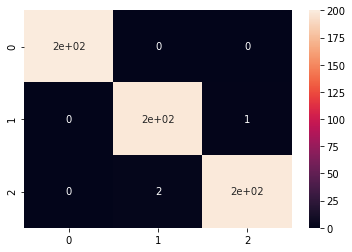

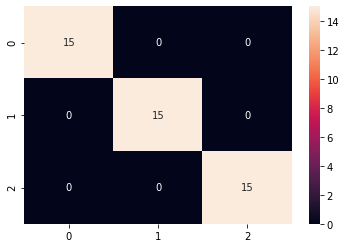

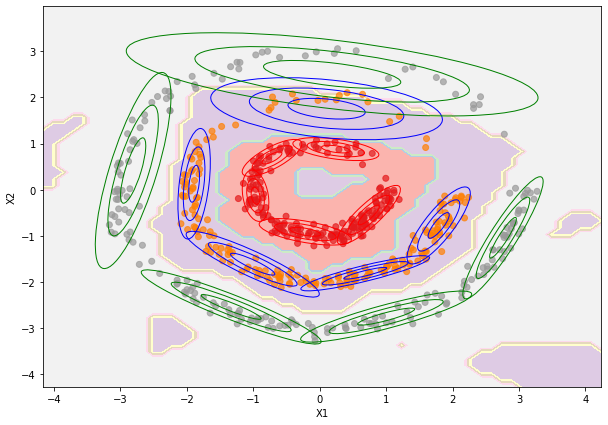

<ipython-input-5-680819d6a44b>:41: UserWarning: No contour levels were found within the data range.
  counto0 = ax2.contour(XX, YY,  Z_1[1][j],levels , offset=-3.15, cmap='winter')
<ipython-input-5-680819d6a44b>:46: UserWarning: No contour levels were found within the data range.
  counto0 = ax2.contour(XX, YY,  Z_1[2][j],levels, offset=-3.15, cmap='summer')


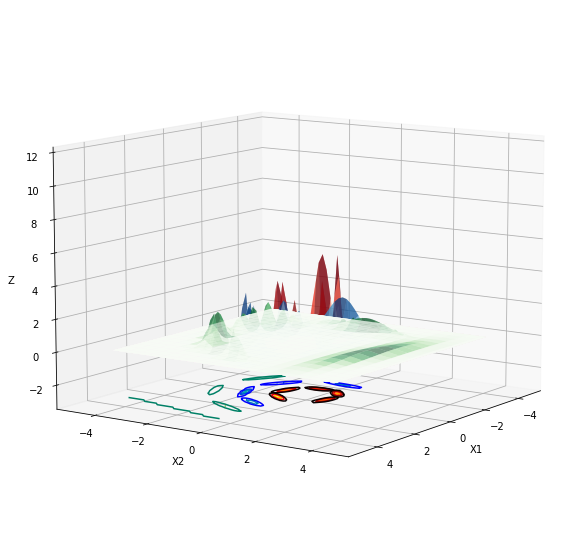

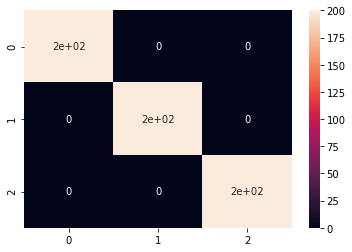

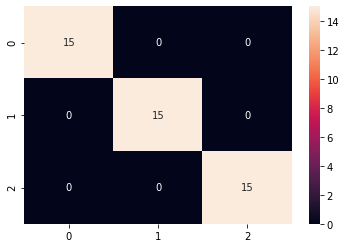

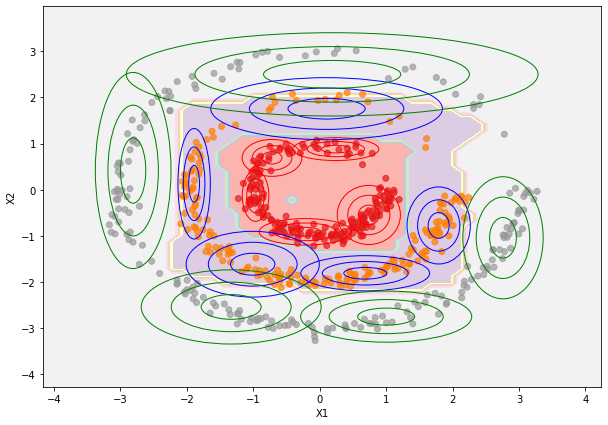

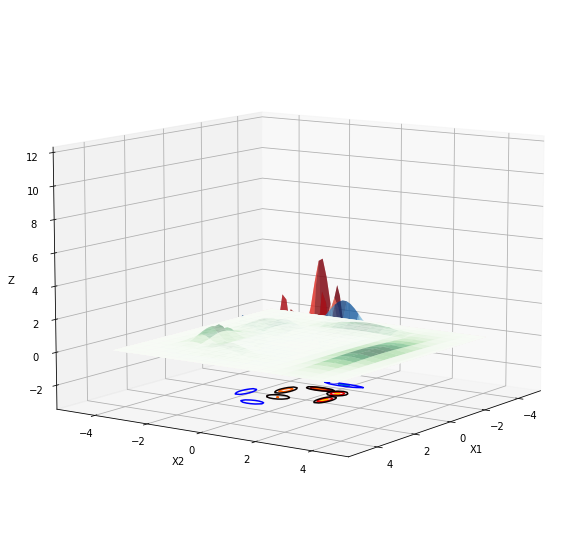

(array([ 99.5, 100. ]), array([100., 100.]), array([100., 100.]))

In [28]:
Q=5
w,mean,cov,p_class = getParameters(feature_train,class_train,Q)
accuracy_dev = np.zeros(2)
accuracy_train = np.zeros(2)
accuracy_test = np.zeros(2)
for i in range(2):
    confusion_matrix = BayesClassifier(feature_train,class_train,Q,w,mean,cov,p_class)
    accuracy_train[i] = np.trace(confusion_matrix)/len(feature_train)*100
    printheatmap(confusion_matrix)
    confusion_matrix = BayesClassifier(feature_dev,class_dev,Q,w,mean,cov,p_class)
    accuracy_dev[i] = np.trace(confusion_matrix)/len(feature_dev)*100
    confusion_matrix = BayesClassifier(feature_test,class_test,Q,w,mean,cov,p_class)
    accuracy_test[i] = np.trace(confusion_matrix)/len(feature_test)*100
    printheatmap(confusion_matrix)
    
    #-------------Clasifying every point on meshgrid--------------
    p = np.zeros((len(reshape_array),class_count))
    for k in range(class_count):
        for j in range(len(reshape_array)):
            p[j][k] = np.log(likelihood(Q,w[k],reshape_array[j],mean[k],cov[k]))+np.log(p_class[k])
    for j in range(len(reshape_array)):
        assign_class_plot_boundary[j] = np.where(p[j]==max(p[j]))[0][0]
    plotDecisionSurfaceGMM(assign_class_plot_boundary,Q,mean,cov)
    
    for k in range(class_count):
        for j in range(Q):
            cov[k][j] = diagonalize(cov[k][j])
accuracy_train,accuracy_dev,accuracy_test

In [29]:
def KNN_density_estimation(k,data,label):
    predicted_class = np.zeros(len(label))
    confusion_matrix = np.zeros((class_count,class_count))
    for i in range(len(data)):
        predicted_class[i] = get_neighbors_class(data[i],k)
        confusion_matrix[int(predicted_class[i])][int(label[i])]+=1
    return confusion_matrix

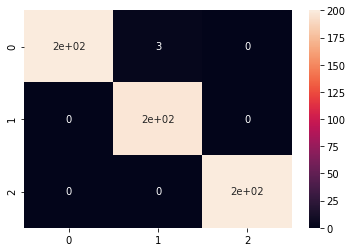

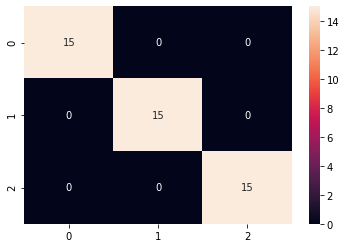

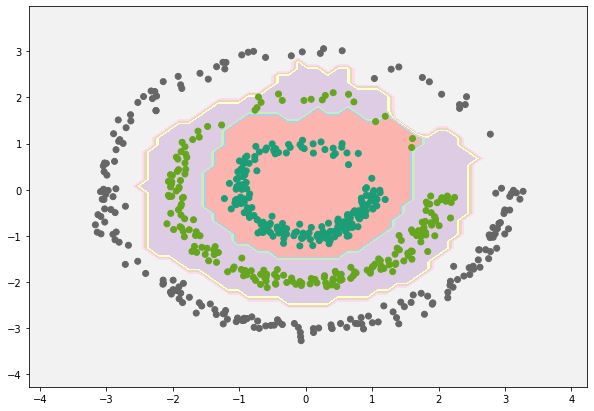

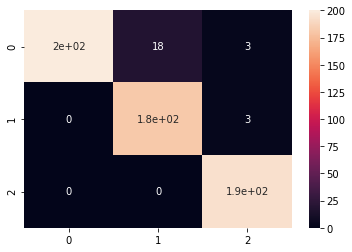

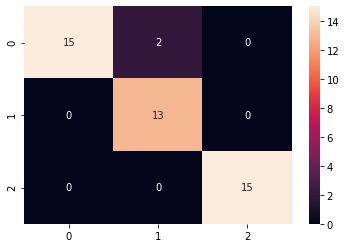

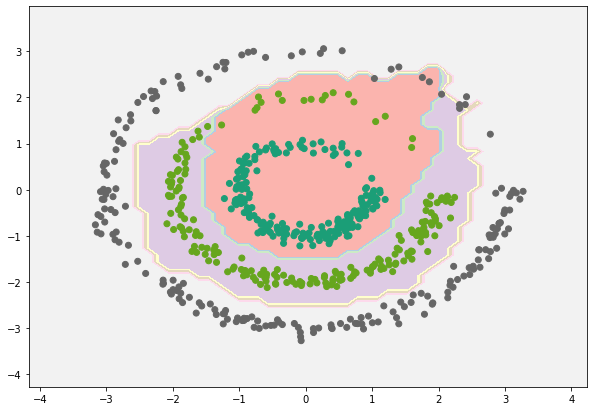

(array([99.5, 96. ]), array([100., 100.]), array([100.        ,  95.55555556]))

In [30]:
accuracy_dev = np.zeros(len(K1))
accuracy_train = np.zeros(len(K1))
accuracy_test = np.zeros(len(K1))
for i in range(len(K1)):
    confusion_matrix = KNN_density_estimation(K1[i],feature_train,class_train)
    accuracy_train[i] = np.trace(confusion_matrix)/len(class_train)*100
    printheatmap(confusion_matrix)
    confusion_matrix = KNN_density_estimation(K1[i],feature_dev,class_dev)
    accuracy_dev[i] = np.trace(confusion_matrix)/len(class_dev)*100
    confusion_matrix = KNN_density_estimation(K1[i],feature_test,class_test)
    accuracy_test[i] = np.trace(confusion_matrix)/len(class_test)*100
    printheatmap(confusion_matrix)
    #-------------Clasifying every point on meshgrid--------------
  
    for j in range(len(reshape_array)):
        assign_class_plot_boundary[j] = get_neighbors_class(reshape_array[j],K1[i])
    plotDecisionSurface(assign_class_plot_boundary,K1[i])
accuracy_train, accuracy_dev, accuracy_test